In [214]:
"""Import everything we need"""
already_installed = !pip list -v | grep deeptrack
if not already_installed:
    !pip install deeptrack==1.0.1
    !pip install mat73
    !pip install tqdm
    !apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng
    !apt install texlive-science

import matplotlib
import os
import random
import mat73
import scipy.io
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import deeptrack as dt
import tensorflow.keras as keras
from tensorflow.math import abs, angle, real, imag, subtract, multiply
from scipy.special import binom
from matplotlib import rc
from scipy.stats import chi2, betaprime, norm
from scipy.optimize import minimize
from matplotlib import colors
from cycler import cycler
from google.colab import drive
from tqdm import tqdm
from math import factorial

rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}', r'\usepackage{siunitx}', r'\usepackage{lipsum}']

In [215]:
#@title
"""Import the validation set"""
""" Function to import used to unpack rows of FFT-field"""
def exp_expand(data,shape=[64,64]):
    x = np.arange(shape[0]) - shape[0] / 2
    y = np.arange(shape[1]) - shape[1] / 2
    X, Y = np.meshgrid(x, y)
    bg=np.zeros((shape[0]*shape[1],))+0j
    X=np.reshape(np.fft.fftshift(X),(shape[0]*shape[1]))
    Y=np.reshape(np.fft.fftshift(Y),(shape[0]*shape[1]))
    RHO=X**2+Y**2
    Inds=np.argsort(RHO)
    Inds=np.sort(Inds[:data.shape[0]])

    bg[Inds[:data.shape[0]]]=data
    bg=np.reshape(bg,(shape[0],shape[1]))
  
    return bg

In [216]:
#@title
def is_arithmetic(l):
    for index in range(len(l) - 1):
        if not (l[index + 1] - l[index] == 1):
            is_arithmetic.counter += 1
            return False
    return True

def extract_pos_and_images(data, shortest_trace=20):
    """Saves images and positions for individual particles."""
    is_arithmetic.counter = 0
    particles_timeseries = []
    particles_positions = []
    num_particles = data.shape[1]

    for i in tqdm(range(num_particles)):
        roi_data = np.array(data[0,i][0,0]["ROI"])
        if shortest_trace <= roi_data[0,0].shape[0] and is_arithmetic(data[0,i][0,0]["Positions"][:,0].flatten()):
            positions = data[0,i][0,0]["Positions"][:,1:4]
            particles_positions.append(positions)

            timeseries = []

            for j in range(roi_data[0,0].shape[0]):
                particleROI = np.expand_dims(np.fft.fftshift(np.fft.ifft2(exp_expand(roi_data[0,0][j,:]))), axis = -1)
                timeseries.append(particleROI)
            particles_timeseries.append(np.array(timeseries))
    print(f"Number of traces discarded because of non-constant time-steps: {is_arithmetic.counter}")
    return particles_positions, particles_timeseries

In [217]:
def create_group(crop_size=64, padding=16, wavelength=525e-9, pixel_size=114e-9):
    crop_propagation_forward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, 1e-7, pixel_size, wavelength)
    crop_propagation_backward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, -1e-7, pixel_size, wavelength)

    args = dt.Arguments(
        translate=lambda: np.random.randn(2)*0.5,
        rotate=lambda: np.random.uniform(0, np.pi*2),
        z=lambda: np.random.randn(1)*20,
    )

    group = ( 
        dt.Affine(rotate=args.rotate) 
        >> dt.Affine(translate=args.translate) 
        >> dt.FourierTransform(padding=padding) 
        >> dt.FourierTransformTransformation(crop_propagation_forward, crop_propagation_backward, args.z, padding=padding) 
        >> dt.InverseFourierTransform(padding=padding) 
    )

    equivariance = (
        dt.models.lodestar.Rotational2DEquivariance(args.rotate)
        >> dt.models.lodestar.TranslationalEquivariance(args.translate)
        >> dt.models.lodestar.Equivariance(1, args.z/10, indexes=2)
    )

    return group, equivariance, (crop_propagation_forward, crop_propagation_backward)

def create_training_set(particles_timeseries):
    imgs = []
    for particle_id in range(0,len(particles_timeseries),1):
        img = np.stack((np.real(particles_timeseries[particle_id])[:,:,:,0], np.imag(particles_timeseries[particle_id][:,:,:,0])), axis=-1)
        img = img[0,:,:,:]
        imgs.append(img)
    return dt.Value(lambda: random.choice(np.array(imgs)))

def plot_dataset(dataset, group, nrows=3, ncols=10):
    for _ in range(nrows):
        fig, axs = plt.subplots(1,ncols,figsize=(25,8))
        for i in range(ncols):
          axs[i].imshow((dataset>>group).update()()[..., 1])
        plt.show()

In [218]:
#@title
"""Create custom layers"""
class CustomLayer(keras.layers.Layer):
    "Takes 2 layers as input and outputs 4 layers."
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        image = tf.dtypes.complex(image[...,0], image[...,1])
        norm_image = subtract(image, 1)
        return tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1)


In [219]:
#@title
"""Create models"""
def create_model(custom_layer, num_layers, image_size, num_outputs):
    model = keras.models.Sequential()
    model.add(keras.Input(shape=(image_size,image_size,2)))
    model.add(custom_layer)
    model.add(keras.layers.Conv2D(64, 3, activation='relu', strides=(2,2)))
    for _ in range(num_layers):
        model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(keras.layers.Conv2D(num_outputs+1,1))
    
    model = dt.models.LodeSTAR(model=model, input_shape=(None, None, 2), num_outputs=num_outputs)
    model.specs = {"Layers": num_layers}
    model.totalhistory = {"total_loss":[], "consistency_loss":[]}
    model.compile(loss=["mae", "mae", "mae"], optimizer=tf.keras.optimizers.Adam(), loss_weights=[1, 1, 1])
    return model


In [220]:
#@title
def save_progress(model, h):
    model.totalhistory["total_loss"].extend(h.history["total_loss"])
    model.totalhistory["consistency_loss"].extend(h.history["consistency_loss"])

def plot_progress(models):
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w

    cc = cycler(color=list('bgrcmyk'))
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
    ax1.set_prop_cycle(cc)
    ax2.set_prop_cycle(cc)

    for i, model in enumerate(models):
        ax1.plot(moving_average(model.totalhistory["total_loss"], 10), label=f"{model.specs}")
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Total Loss")
        ax1.set_yscale("log")
        ax1.legend(prop={'size': 15})

        ax2.plot(moving_average(model.totalhistory["consistency_loss"], 10), label=f"{model.specs}")
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("Consistency loss")
        ax2.set_yscale("log")
        ax2.legend(prop={'size': 15})

    ax1.grid(True)
    ax2.grid(True)
    plt.show()


In [221]:
#@title
def get_propagation_matrix(shape, to_z, pixel_size, wavelength):

    k = 2 * np.pi / wavelength
    yr, xr, *_ = shape

    x = 2 * np.pi / pixel_size * np.arange(-(xr / 2 - 1 / 2), (xr / 2 + 1 / 2), 1) / xr
    y = 2 * np.pi / pixel_size * np.arange(-(yr / 2 - 1 / 2), (yr / 2 + 1 / 2), 1) / yr
    KXk, KYk = np.meshgrid(x, y)

    K = np.real(
        np.sqrt(np.array(1 - (KXk / k) ** 2 - (KYk / k) ** 2, dtype=np.complex64))
    )
    C = np.fft.fftshift(((KXk / k) ** 2 + (KYk / k) ** 2 < 1) * 1.0)

    return C * np.fft.fftshift(np.exp(k * 1j * to_z * (K - 1)))

def fourier_transform(image, padding=32):
    im = np.pad(image, ((padding, padding), (padding, padding)), mode="symmetric")
    return np.fft.fft2(im)

def inverse_fourier_transform(image, padding=32):
    im = np.fft.ifft2(image)
    return im[padding:-padding, padding:-padding]

def fourier_transform_transformation(image, Tz, Tzinv, i):
    if i < 0:
        image *= Tzinv ** np.abs(i)
    else:
        image *= Tz ** i
    return image

def propagate(image, z, prop_matrices, padding):
    """Re-propagate the images using PAS"""
    crop_propagation_forward, crop_propagation_backward = prop_matrices
    ft_image = fourier_transform(image[:,:,0], padding=padding)
    prop_ft_image = fourier_transform_transformation(ft_image, crop_propagation_backward, crop_propagation_forward, -z)
    return np.expand_dims(inverse_fourier_transform(prop_ft_image, padding=padding),axis=-1)

In [222]:
#@title
def predict_on_stack(model, val_stack):
    """returns a numpy tensor containing propagated distance as well as the prediction, for ever propagation distance and every image images"""
    print(val_stack.shape)
    plt.imshow(val_stack[0,:,:,1])
    plt.show()
    try:
        dets = np.array(model.predict_and_detect(val_stack, mode="ratio"))
    except ValueError as E:
        dets = np.expand_dims(np.zeros((val_stack.shape[0],3)), axis=0)
        print(E)
    dets = reshape_dets(dets, val_stack.shape[2])
    return dets

def reshape_dets(dets, image_size):
    """Removes all particles but the one closest to the center. If no particles are detected, sets the value to 0."""
    out = []
    for coords in dets:
        if coords.shape != (0, 3):
            x, y = image_size//2, image_size//2
            idx = np.argmin(np.array(coords[:,:2]- np.array((x, y))), axis=0)[0]
            out.append(coords[idx,:])
        else:
            print("DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.")
            out.append([0,0,0])
    return np.array(out)

def create_validation_stack(images, z_list, prop_matrices, padding):
    """Creates a set of images propagated to various focal planes, given by z_list."""
    output = []
    for i in range(images.shape[0]):
        image = images[i,:,:,:]
        stack = []
        for z in z_list:
            stack.append(propagate(image, z, prop_matrices, padding))
        output.append(stack)
    return np.stack((np.real(output), np.imag(output)), axis=-1)[:,:,:,:,0,:]

def evaluate_model(model, val_stack, prop_range):
    """Evaluates a model given a set of repropagated images, 
    by checking if the model is internally consistent in the determination of the z-coordinate"""
    accs=[]
    for i in range(min(val_stack.shape[0], 15)):
        acc = np.array([predict_on_stack(model, val_stack[i])[:,2]])
        acc = acc - np.mean(acc)
        accs.append(acc)
    accs = np.array(accs)

    fig, axs = plt.subplots(1,2, figsize=(16,6))
    for i in range(accs.shape[0]):
        axs[0].plot(prop_range/10, prop_range/10, 'k')
        axs[0].plot(accs[i,:].flatten(), prop_range/10, '-.')
        axs[0].set_title("Numeriskt ompropagerade bilder", fontsize=22)
        axs[0].set_xlabel(r"Predikterat avstånd [\SI{}{\micro\meter}]", fontsize=16)
        axs[0].set_ylabel(r"Propagerat avstånd [\SI{}{\micro\meter}]", fontsize=16)
        axs[0].set_xticks(np.linspace(prop_range[0], prop_range[-1], 9)/10)
        axs[0].set_yticks(np.linspace(prop_range[0], prop_range[-1], 9)/10)
        axs[0].grid(True)

    for i in range(accs.shape[-1]):
        axs[1].scatter((prop_range/10)[i], np.std(accs[:,:,i]), c="r", marker="x")
        axs[1].set_title("Numeriskt ompropagerade bilder", fontsize=22)
        axs[1].set_xlabel(r"Standardavvikelse i predikterat avstånd [\SI{}{\micro\meter}]", fontsize=16)
        axs[1].set_ylabel(r"Propagerat avstånd [\SI{}{\micro\meter}]", fontsize=16)
        axs[1].set_xticks(np.linspace(prop_range[0], prop_range[-1], 9)/10)
        axs[1].set_ylim([0, 2.5])
        axs[1].grid(True)
    plt.savefig("validering.png")
    plt.show()


def plot_consistency(model, validation_set, prop_range, prop_matrices, padding):
    val_stack = create_validation_stack(validation_set, prop_range, prop_matrices, padding)
    evaluate_model(model, val_stack, prop_range)

In [223]:
def calc_sigma2(arr):
    """
    Takes a time series array as input and returns a CVE of sigma^2.

    Source:
    https://sci-hub.hkvisa.net/10.1103/PhysRevE.89.022726
    """
    sigma2 = -np.mean(
        np.multiply(
            np.diff(arr[:-1]), 
            np.diff(arr[1:])
            ))
    return sigma2

def calculate_diffusion(traces, delta_time, shortest_trace=20):
    """
    Takes a list of traces with x,y and z-positions. Returns estiamtes of the
    diffusion constant in the x and z-directions.

    Source:
    https://sci-hub.hkvisa.net/10.1103/PhysRevE.89.022726
    """
    _traces = [trace for trace in traces if trace.shape[1]>shortest_trace]

    sigma_x2 = np.array([calc_sigma2(trace[0,:]) for trace in _traces])
    sigma_z2 = np.array([calc_sigma2(trace[2,:]) for trace in _traces])
    print(f"Median av sigma_z^2: {np.median(sigma_z2)}")

    D_x, D_z = [], []
    for i, pos in enumerate(_traces):
      D_x.append((
          np.mean(np.diff(pos[0,:])**2)
          -2*sigma_x2[i])
          /(2*delta_time)
          )
      D_z.append((
          np.mean(np.diff(pos[2,:])**2)
          -2*sigma_z2[i])
          /(2*delta_time)
          )
    print(f"sigma2_x, sigma2_z: {np.median(sigma_x2):.5f}, {np.median(sigma_z2):.5f}")
    return D_x, D_z


def confint(Dz, Dx, conf=0.95):
    """
    Takes diffusion constants Dz and Dx as numpy arrays.
    Returns confidence interval for median(Dz)/median(Dx) where significance is defined by conf.

    Source:
    https://sci-hub.hkvisa.net/10.3102/1076998620934125 page 5-6
    """
    Dz, Dx, n = sorted(Dz), sorted(Dx), len(Dz)
    o1 = round(n/2-np.sqrt(n))
    o2 = n+1-round(n/2-np.sqrt(n))
    alpha_2 = 0.5**n*sum([binom(n,i) for i in range(o1)])
    z = norm.ppf(1-alpha_2)

    var_z = ((Dz[o2]-Dz[o1])/(2*z))**2
    var_x = ((Dx[o2]-Dx[o1])/(2*z))**2
    theta = np.median(np.median(Dz)/np.median(Dx))

    ln = np.log(theta)
    pm = norm.ppf(0.5+conf/2)*np.sqrt(var_z/np.median(Dz)**2+var_x/np.median(Dx)**2)
    return np.exp(ln-pm), np.exp(ln+pm)

In [224]:
def train_on_particle(model, particle, num_outputs, group, equivariance, epochs, verbose=0):
    training_set = create_training_set(particle)
    generator = dt.models.lodestar.LodeSTARGenerator(
        training_set,
        num_outputs=num_outputs, 
        transformation_function=(group, equivariance), 
        batch_size=8, 
        min_data_size=100, 
        max_data_size=101,
    )

    const = 10
    progress = [] 
    for _ in tqdm(range(epochs//const)):
        with generator:
            h = model.fit(generator, epochs=const, steps_per_epoch=100, verbose=verbose)
            progress.extend(h.history["total_loss"])
            fig, ax = plt.subplots(1,1,figsize=(8,6))
            ax.plot(progress)
            ax.grid(True)
            ax.set_ylim([0, max(progress)+0.5])
            ax.set_ylabel(r"Total loss", fontsize=16)
            ax.set_xlabel(r"Epok", fontsize=16)
            ax.set_title("träning... etc", fontsize=22)
            ax.legend("Train", prop={'size': 15})
            plt.savefig("training_progress.png")
            plt.show()


def compare_lode_matlab(model, particles, particles_positions,  verbose=1):
    z_mults = []
    traces_matlab = []
    traces_new = []

    for particle_id in tqdm(range(len(particles))):

        timeseries = np.stack((np.real(particles[particle_id][:,:,:,0]), np.imag(particles[particle_id][:,:,:,0])), axis=-1)
        corrections = predict_on_stack(model, timeseries)

        x_lode, y_lode, z_lode = corrections[:,0], corrections[:,1], corrections[:,2]
        x_matlab, y_matlab, z_matlab = particles_positions[particle_id][:,0], particles_positions[particle_id][:,1], particles_positions[particle_id][:,2]

        z_lode = z_lode - np.mean(z_lode)
        x_new, y_new, z_new = x_matlab+(x_lode-32)*0.114, y_matlab+(y_lode-32)*0.114, z_matlab+z_lode # byt ut mot pixel_size!

        z_mult = minimize(lambda x: np.abs(calc_sigma2(x*z_matlab + z_lode)), [0], method="Powell").x
        if verbose:
            if particle_id%100==0:
                fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,6))

                fig.suptitle('Uppskattade partikelbanor', fontsize=22)
                t_range = np.linspace(0, len(z_new)/41, len(z_new)) # OBS: 1/41 i tidssteg i plot
                ax1.grid(True)
                ax1.set_ylabel(r"x-koordinat [\SI{}{\micro\meter}]", fontsize=16)
                ax1.set_xlabel(r"Tid [\SI{}{\second}]", fontsize=16)
                ax1.plot(t_range, x_matlab, 'b')
                ax1.plot(t_range, x_new, 'r')
                ax1.legend(["Ursprunglig", "Korrigerad"], prop={'size': 15})

                ax2.grid(True)
                ax2.set_ylabel(r"z-koordinat [\SI{}{\micro\meter}]", fontsize=16)
                ax2.set_xlabel(r"Tid [\SI{}{\second}]", fontsize=16)
                ax2.plot(t_range, z_matlab, 'b')
                ax2.plot(t_range, z_new, 'r')
                ax2.legend(["Ursprunglig", "Korrigerad"], prop={'size': 15})
                plt.savefig(f"partikel_{particle_id}.png")
                plt.show()

        z_mults.append(z_mult)
        fac = 1.203#1.2415
        traces_matlab.append(np.array([x_matlab, y_matlab, z_matlab*fac]))
        traces_new.append(np.array([x_matlab, y_matlab, z_new*fac])) #x & y matlab!!
    return traces_matlab, traces_new, z_mults

In [225]:
def plot_diffusion(Dx, Dz, colors, title, xlabel):
    range=(-0.5,3*np.median(np.array([Dx, Dz])))
    nbins=20

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.hist(Dx, nbins, alpha=0.5, range=range, facecolor=seaborn.color_palette("colorblind")[colors[0]], label=r"$D_{\text{x}}$", edgecolor='grey')
    ax.hist(Dz, nbins, alpha=0.5, range=range, facecolor=seaborn.color_palette("colorblind")[colors[1]], label=r"$D_{\text{z}}$", edgecolor='grey')
    ax.set_ylabel("Frekvens", fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_title(title, fontsize=22)
    ax.legend(prop={'size': 15})
    plt.savefig("dist.png")
    plt.show()

def plot_ratio(Dx, Dz):
    Dz, Dx = np.array(Dz), np.array(Dx)
    range=(0,3*np.median(Dz/Dx))
    nbins=20

    lowlim, highlim = confint(Dz, Dx)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    ax1.hist(Dz/Dx, nbins, alpha=0.5, range=range, facecolor="blue", edgecolor='grey')
    ax1.axvspan(lowlim, highlim, alpha=0.3, color='black', label="Skattat intervall", edgecolor='transparent')
    ax1.axvline(1.265625, alpha=1, color='black', linestyle='--', label='Förväntat värde')
    ax1.set_ylabel("Frekvens", fontsize=16)
    ax1.set_title(r"Distribution av ratio mellan $D_\text{z}$ och $D_\text{x}$", fontsize=16)
    ax1.set_xlabel(r"$D_\text{z}/D_\text{x}$", fontsize=22)
    ax1.legend(prop={'size': 15})

    ax2.hist(np.sqrt(np.abs(Dz/Dx)), nbins, alpha=0.5, range=range, facecolor="blue", edgecolor='grey')
    ax2.axvspan(np.sqrt(lowlim), np.sqrt(highlim), alpha=0.3, color='black', label="Skattat intervall", edgecolor='transparent')
    ax2.axvline(1.125, alpha=1, color='black', linestyle='--', label="Förväntat värde")
    ax2.set_ylabel("Frekvens", fontsize=16)
    ax2.set_title(r"Distribution av ratio mellan $n_\text{z}$ och $n_\text{x}$", fontsize=16)
    ax2.set_xlabel(r"$n_\text{z}/n_\text{x}$", fontsize=22)
    ax2.legend(prop={'size': 15})
    plt.savefig("kvot_dist.png")
    plt.show()

def plot_n(Dx, Dz, n):
    Dz, Dx = np.array(Dz), np.array(Dx)
    range=(0,3*np.median(Dz/Dx))
    nbins=30

    ratio = Dz/Dx
    ratio[ratio<0] = 0

    lowlim, highlim = confint(Dz, Dx)
    highlim, lowlim = 1.5/np.sqrt(lowlim), 1.5/np.sqrt(highlim) #1.5 för olja i objektiv

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.hist(1.5/np.sqrt(ratio), nbins, alpha=0.5, range=range, facecolor="blue", edgecolor='grey')
    ax.axvspan(lowlim, highlim, alpha=0.3, color='black', label="Skattat intervall", edgecolor='transparent')
    ax.axvline(n, alpha=1, color='black', linestyle='--', label='Förväntat värde')
    ax.set_ylabel("Frekvens", fontsize=16)
    ax.set_title(r"Skattat brytningsindex $n_\text{medium}$", fontsize=16)
    ax.set_xlabel(r"$n_\text{medium}$", fontsize=22)
    plt.savefig("brytningsindex.png", pad_inches=0, bbox_inches='tight')
    plt.show()
    return lowlim, highlim

In [227]:
#@title
def save_weights(path, model):
    model.save_weights(path)

def load_weights(path, model):
    model.load_weights(path)
    return model

def concatenate_files(path, filenames): #concatenates files pair-wise
    files = []
    for idx in range(0, len(filenames), 2):
        print(f"Joining {filenames[idx]} with {filenames[idx+1]}")
        first_file = scipy.io.loadmat(path + filenames[idx])['CompletedTraces']
        second_file = scipy.io.loadmat(path + filenames[idx+1])['CompletedTraces']
        new_file=np.concatenate((first_file, second_file), axis=1)
        files.append(new_file)
    return files

In [228]:
%matplotlib inline

drive.mount('/content/drive')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)    
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

weights_path = "/content/drive/My Drive/saved_weights/"
data_path = "/content/drive/My Drive/twilight_data/"
crop_size = 64
padding = 16
wavelength = 532-9
pixel_size = 114e-9
num_outputs = 3
image_size = 64
delta_time = 1/41
num_layers = 7
shortest_trace = 50
epochs_to_train = 100
validation_ids = [1]

filenames = !ls "/content/drive/My Drive/twilight_data/"
filenames = sorted([filename for filename in filenames if (".mat" in filename) and ("wGold" in filename)])
print(filenames)

try:
    model = load_weights(weights_path+"/"+str(num_layers), create_model(CustomLayer(), num_layers, image_size, num_outputs))
    print("WEIGHTS LOADED")
    train_flag = False
except:
    model = create_model(CustomLayer(), num_layers, image_size, num_outputs)
    print("WEIGHTS NOT LOADED, NEW MODEL CREATED")
    train_flag = True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Sun May  8 10:21:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    27W /  70W |   1046MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+------

Joined 0wtGlycerol_300nmSilica_wGold_1_3msExp_41fpsEvery1_1_movie_1.aviCompletedTraces.mat with 0wtGlycerol_300nmSilica_wGold_1_3msExp_41fpsEvery1_1_movie_1.aviCompletedTraces0.mat
Loading file: 0wtGlycerol_300nmSilica_wGold_1_3msExp_41fpsEvery1_1_movie_1.aviCompletedTraces0.mat 

100%|██████████| 300/300 [00:03<00:00, 80.59it/s] 


Number of traces discarded because of non-constant time-steps: 75


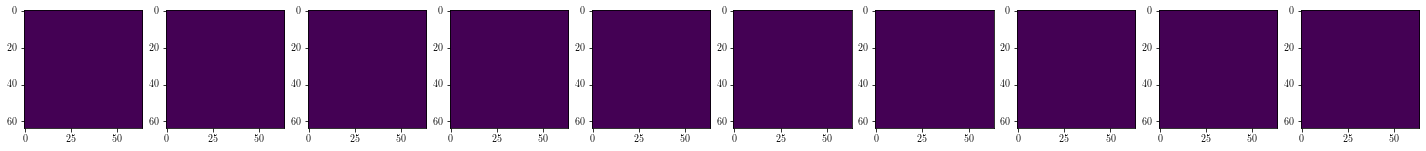

(50, 64, 64, 2)


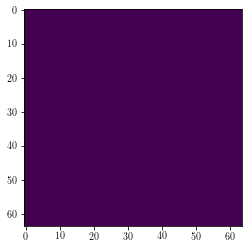

DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FI

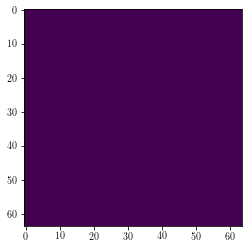

DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FI

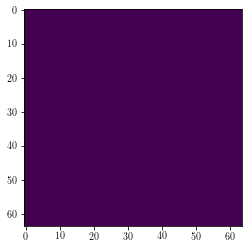

DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FI

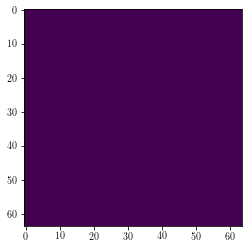

DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FI

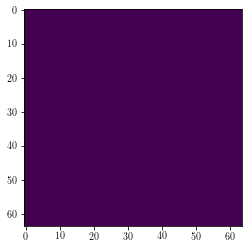

DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FI

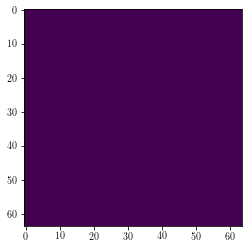

DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FI

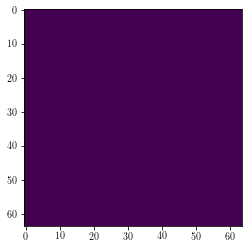

DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FI

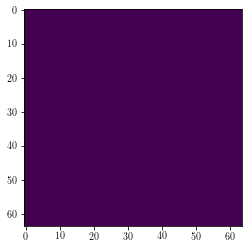

DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FI

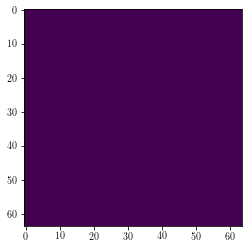

DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FI

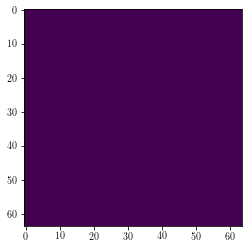

DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FI

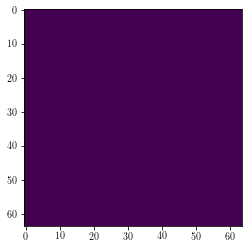

DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FI

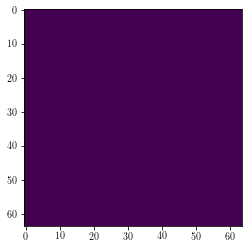

DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FI

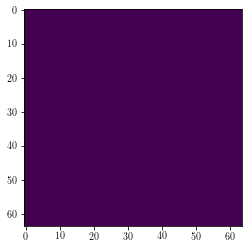

DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FI

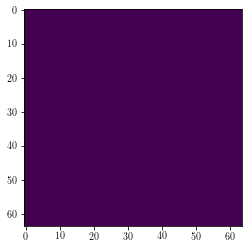

DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FI

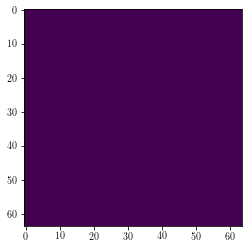

DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FIND AND PARTICLE IN IMAGE; ADDING [0,0,0] AS CORRECTION.
DID NOT FI

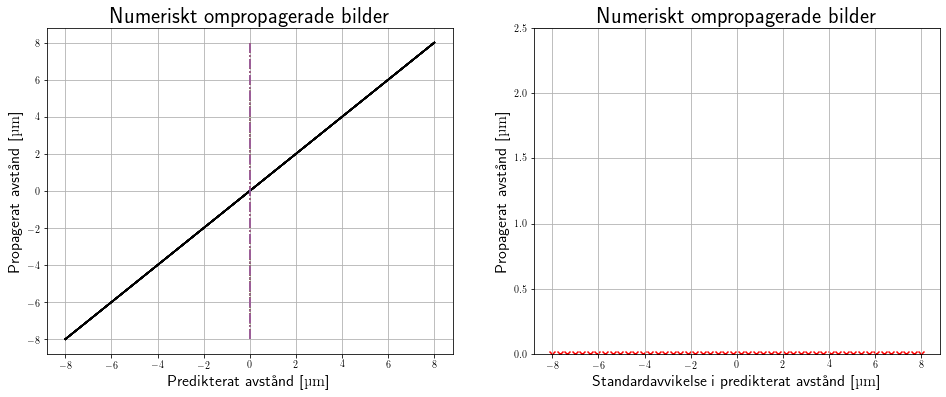

Creating corrected traces 

  0%|          | 0/66 [00:00<?, ?it/s]

(83, 64, 64, 2)


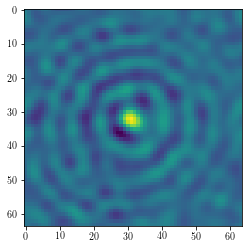

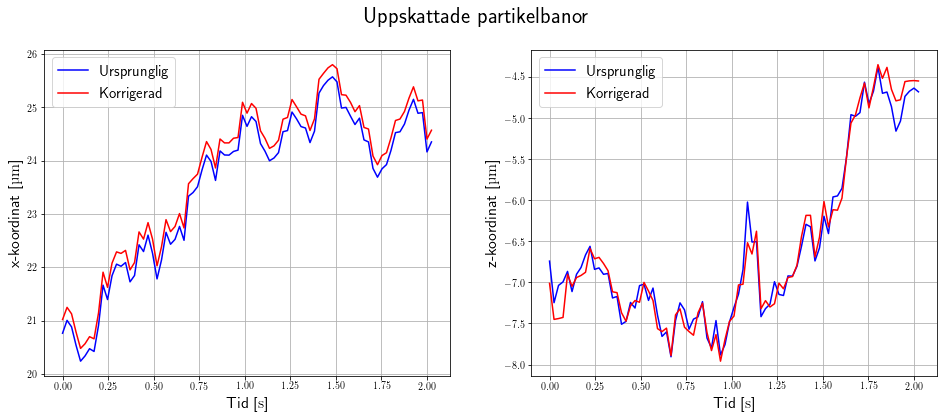

  2%|▏         | 1/66 [00:00<00:53,  1.22it/s]

(88, 64, 64, 2)


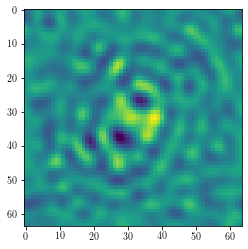

  3%|▎         | 2/66 [00:01<00:32,  1.94it/s]

(60, 64, 64, 2)


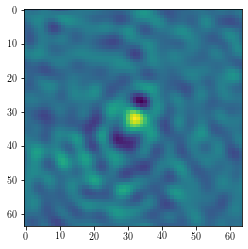

  5%|▍         | 3/66 [00:01<00:24,  2.53it/s]

(76, 64, 64, 2)


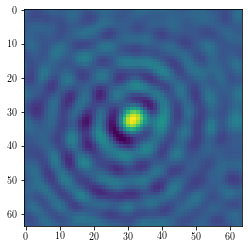

  6%|▌         | 4/66 [00:01<00:21,  2.84it/s]

(123, 64, 64, 2)


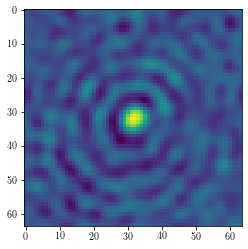

  8%|▊         | 5/66 [00:02<00:21,  2.78it/s]

(59, 64, 64, 2)


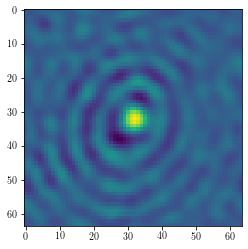

  9%|▉         | 6/66 [00:02<00:19,  3.02it/s]

(51, 64, 64, 2)


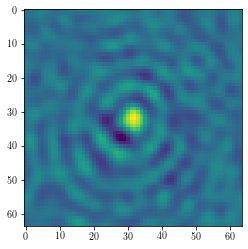

 11%|█         | 7/66 [00:02<00:18,  3.22it/s]

(74, 64, 64, 2)


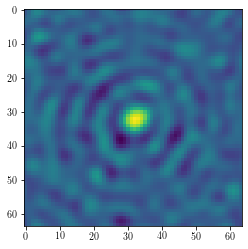

 12%|█▏        | 8/66 [00:02<00:17,  3.24it/s]

(60, 64, 64, 2)


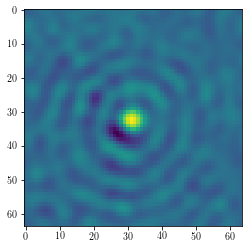

 14%|█▎        | 9/66 [00:03<00:16,  3.40it/s]

(65, 64, 64, 2)


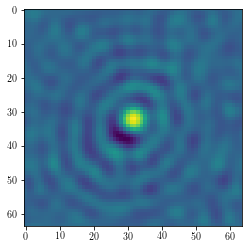

 14%|█▎        | 9/66 [00:03<00:21,  2.66it/s]


KeyboardInterrupt: ignored

In [229]:
n_range_lode, n_range_matlab = [], []
ns = {"0":1.33303, "2":1.36404, "5":1.39809} #http://edge.rit.edu/edge/P13051/public/Research%20Notes/refractive%20index%20glycerin%20water.pdf
current_file_index = 0
while current_file_index < len(filenames):
    file = scipy.io.loadmat(data_path + filenames[current_file_index])['CompletedTraces']

    i=1
    while current_file_index+i<len(filenames) and filenames[current_file_index][:50] in filenames[current_file_index+i]:
        second_file = scipy.io.loadmat(data_path + filenames[current_file_index+i])['CompletedTraces']
        file=np.concatenate((file, second_file), axis=1)
        print(f"Joined {filenames[current_file_index]} with {filenames[current_file_index+i]}")
        i+=1
    current_file_index +=i

    file = file[:,:300]
    print(f"Loading file: {filenames[current_file_index-1]}", end=" ")
    particles_positions, particles_timeseries = extract_pos_and_images(file, shortest_trace=shortest_trace)

    group, equivariance, prop_matrices = create_group(crop_size=crop_size, padding=padding, wavelength=wavelength, pixel_size=pixel_size)
    plot_dataset(create_training_set(particles_timeseries), group, nrows=1)

    if train_flag:
        train_on_particle(model, particles_timeseries, num_outputs, group, equivariance, epochs_to_train, verbose=0) # change verbose to show training progress or not.
        save_weights(weights_path+"/"+str(num_layers), model)
        train_flag = False
    else:
        train_flag = False

    for validation_id in validation_ids:
        plot_consistency(model, particles_timeseries[validation_id], np.linspace(-80,80,50), prop_matrices, padding)

    print(f"Creating corrected traces", end=" ")
    traces_matlab, traces_lode, z_mults = compare_lode_matlab(model, particles_timeseries, particles_positions, verbose=1) # change verbose to plot paths or not.
    print(f"OPTIMAL Z_MULT: {np.median(z_mults)}")

    Dx, Dz = calculate_diffusion(traces_lode, delta_time, shortest_trace=shortest_trace)
    plot_diffusion(Dx, Dz, (9,3), "Diffusionskonstanter tangentiellt och parallellt med kameraplanet", r"$D_\text{x}$ och $D_\text{z}$ [\SI{}{\micro\meter^2\second^{-1}}]")
    plot_ratio(Dx, Dz)
    low, high = plot_n(Dx, Dz, ns[filenames[current_file_index-1][0]])
    print(f"intervall: ({low:.3f}, {high:.3f}), teori: {ns[filenames[current_file_index-1][0]]:.3f}")
    n_range_lode.append((low, high))

    Dx, Dz = calculate_diffusion(traces_matlab, delta_time, shortest_trace=shortest_trace)
    #plot_diffusion(Dx, Dz, (9,3), "Diffusionskonstanter tangentiellt och parallellt med kameraplanet", r"$D_\text{x}$ och $D_\text{z}$ [\SI{}{\micro\meter^2\second^{-1}}]")
    #plot_ratio(Dx, Dz)
    low, high = plot_n(Dx, Dz, ns[filenames[current_file_index-1][0]])
    print(f"intervall: ({low:.3f}, {high:.3f}), teori: {ns[filenames[current_file_index-1][0]]:.3f}")
    n_range_matlab.append((low, high))

n_range_lode = np.array(n_range_lode)
n_range_matlab = np.array(n_range_matlab)

In [245]:
file = scipy.io.loadmat(data_path + "0wtGlycerol_300nmSilica_wGold_1_3msExp_41fpsEvery1_1_movie_1.aviCompletedTraces0")['CompletedTraces'][:,:100]
particles_positions, particles_timeseries = extract_pos_and_images(file, shortest_trace=shortest_trace)

snrs, sigmas = [], []
ALL_USED_DATA = []
for id in range(3):
  print(id)
  chosen_trace = particles_timeseries[0]

  x = np.arange(image_size) - image_size/2
  y = np.arange(image_size) - image_size/2
  X, Y = np.meshgrid(x,y)
  RHO = np.sqrt(X**2 + Y**2)
  steps=9
  noisy_sets = []
  for i in range(steps):
    noisy_set=[]
    for img in chosen_trace:
      fft_img = np.fft.fftshift(np.fft.fft2(img[..., 0]))
      tmp = (1*np.random.randn(64, 64) + 1j * np.random.randn(64, 64))*i**2/5
      tmp[RHO>=11]= 0
      noisy_set.append(np.fft.ifft2(np.fft.ifftshift(fft_img+tmp)))
    noisy_sets.append(noisy_set)

  noisy_sets = np.array(noisy_sets)
  noisy_sets = np.moveaxis(noisy_sets, [0,1,2,3], [3,0,1,2])
  ALL_USED_DATA.append(noisy_sets)
  
ALL_USED_DATA = np.array(ALL_USED_DATA)

100%|██████████| 100/100 [00:01<00:00, 63.45it/s]


Number of traces discarded because of non-constant time-steps: 8
0
1
2


In [ ]:
#np.save("/content/drive/My Drive/SNR/snr_data.npy", ALL_USED_DATA)
print(ALL_USED_DATA.shape)
#AXIS 0: ITERATION, AXIS 1: BILDNUMMER I TRACE, AXIS 2&3: 64x64 FÄLTBILD, AXIS 4: BRUSNIVÅ, INDEX 0 LÄGST

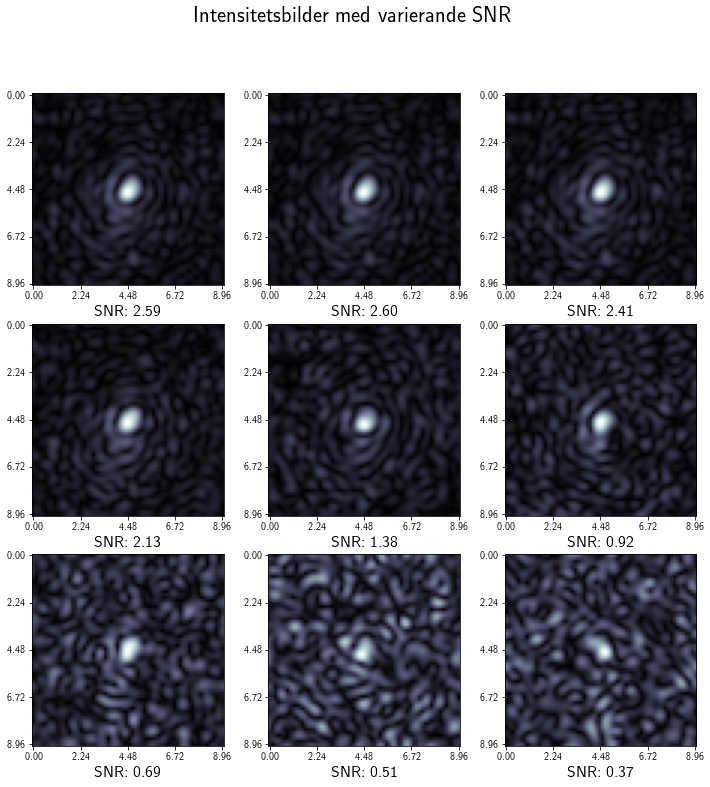

In [253]:
fig, axs = plt.subplots(3,3,figsize=(12,12))
for i in range(3):
  for j in range(3):
    idx = 3*i+j
    current_set = ALL_USED_DATA[0,:,:,:,idx:idx+1]

    mean_image = np.array([np.mean(current_set, axis=0) for i in range(current_set.shape[0])])
    signal = np.sum(np.abs(mean_image[0,:,:,0]))
    noise_and_signal = np.sum(np.abs(current_set[0,:,:,0]))
    noise = noise_and_signal - signal
  
    snr = signal/noise
    axs[i,j].imshow(np.abs(ALL_USED_DATA[0,0,:,:,idx]), cmap='bone')
    axs[i,j].set_xticks(np.linspace(0, 63, 5))
    axs[i,j].set_xticklabels([f"{fl:.2f}" for fl in np.linspace(0, 8.96, 5)])
    axs[i,j].set_yticks(np.linspace(0, 63, 5))
    axs[i,j].set_yticklabels([f"{fl:.2f}" for fl in np.linspace(0, 8.96, 5)])
    fig.suptitle("Intensitetsbilder med varierande SNR", fontsize=22)
    axs[i,j].set_xlabel(f"SNR: {snr:.2f}", fontsize=16)

plt.savefig("added_noise.png", pad_inches=0.05, bbox_inches='tight')
plt.show()


In [ ]:
from matplotlib.transforms import Affine2D

y_matlab, yerr_matlab = np.mean(n_range_matlab, axis=1), np.squeeze(np.diff(n_range_matlab, axis=1))
y_lode, yerr_lode = np.mean(n_range_lode, axis=1), np.squeeze(np.diff(n_range_lode, axis=1))

actual_data = {
    'x': list(range(3)),
    'y': [1.33303, 1.36404, 1.39809],}
lode_data = {
    'x': list(range(3)),
    'y': y_lode,
    'yerr': yerr_lode} # intervallgränser undre och övre
matlab_data = {
    'x': list(range(3)),
    'y': y_matlab,
    'yerr': yerr_matlab} # intervallgränser undre och övre


fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(actual_data['x'], actual_data['y'], 'sk', alpha=1, markersize=8)
for data in [matlab_data, lode_data]:
    ax.errorbar(**data, alpha=.8, fmt='.', capsize=7, capthick=2, markersize=0)
    ax.set_title("Uppskattade brytningsindex", fontsize=22)
    ax.set_ylabel(r"Predikterat brytningsindex {n}", fontsize=16)
    ax.grid(True)

    my_xticks = [r"\SI{0}{\percent} glycerin", r"\SI{25}{\percent} glycerin", r"\SI{50}{\percent} glycerin"]
    plt.xticks(list(range(3)), my_xticks)
    
ax.legend(["Känt brytningsindex", "Klassisk algoritm", "LodeSTAR"], prop={'size': 15})
#ax.plot(actual_data['x'], actual_data['y'], '-.k', alpha=0.7)
plt.show()

In [ ]:
#noise_data = np.load("/content/drive/My Drive/SNR/snr_data.npy")
"IMPORTERA MATLAB-Z"
"TA PARTIKELPOS-Z"
"ADDERA"
"z_corrections_matlab_snr = ..."
noise_data = ALL_USED_DATA
print(noise_data.shape)
sigmas_lode, sigmas_matlab = [], []
snrs = []
for i in range(noise_data.shape[0]):
  noisy_sets = noise_data[i,...]
  particle_id = 0
  snr = []
  sigma_lode, sigma_matlab = [], []  
  for step in range(noisy_sets.shape[-1]):
      print(step)
      current_set = noisy_sets[:,:,:,step:step+1]
      mean_image = np.array([np.mean(current_set, axis=0) for i in range(current_set.shape[0])])

      signal = np.sum(np.abs(mean_image[0,:,:,0]))
      noise_and_signal = np.sum(np.abs(current_set[0,:,:,0]))
      noise = noise_and_signal - signal

      traces_matlab, traces_lode, z_mults = compare_lode_matlab(model, [current_set], [particles_positions[particle_id]], verbose=0)
      sigma2_lode = calc_sigma2(traces_lode[0][2])
      #sigma2_matlab = calc_sigma2(traces_matlab[0][2]+z_corrections_matlab_snr)

      snr.append(signal/noise)
      sigma_lode.append(np.sqrt(sigma2_lode))
      #sigma_matlab.append(np.sqrt(sigma2_lode))

  snrs.append(snr)
  sigmas_lode.append(sigma_lode)
  #sigmas_matlab.append(sigma_matlab)

  y_lode = np.mean(np.array(sigmas_lode), axis=0)
  yerr_lode = np.std(np.array(sigmas_lode), axis=0)
  #y_matlab = np.mean(np.array(sigmas_matlab), axis=0)
  #yerr_matlab = np.std(np.array(sigmas_matlab), axis=0)
  x = np.median(np.array(snrs), axis=0)

  fig, ax = plt.subplots(1,1,figsize=(8,6))
  ax.errorbar(x, y_lode, yerr=yerr_lode*2, alpha=.8, fmt='.', capsize=7, capthick=2, markersize=0)
  #ax.errorbar(x, y_matlab, yerr=yerr_matlab*2, alpha=.8, fmt='.', capsize=7, capthick=2, markersize=0)
  ax.plot(snr, sigma_lode, 'k-.', alpha=0.2)
  ax.grid(True)
  ax.set_xlabel("SNR")
  ax.set_ylabel("Sigma")
  ax.legend(["LodeSTAR", "Klassisk algoritm"], prop={'size': 15})
  #ax.set_ylim([0,3])
  #ax.set_xlim([0,3])

  plt.show()

In [ ]:
file = scipy.io.loadmat(data_path + filenames[0])['CompletedTraces']
particles_positions, particles_timeseries = extract_pos_and_images(file, shortest_trace=shortest_trace)
models=[]
epochs_to_train=60
for _ in range(20):
    models.append(load_weights(weights_path+"/"+str(num_layers), create_model(CustomLayer(), num_layers, image_size, num_outputs)))

for i, model in enumerate(models):
    train_on_particle(model, particles_timeseries, num_outputs, group, equivariance, epochs_to_train, verbose=0)
    save_weights(weights_path+"/"+str(num_layers)+"/"+str(i), model)
    traces_matlab, traces_lode, z_mults = compare_lode_matlab(model, particles_timeseries, particles_positions, verbose=0)
    Dx, Dz = calculate_diffusion(traces_lode, delta_time, shortest_trace=shortest_trace)
    low, high = plot_n(Dx, Dz, ns[filenames[0][0]])
    print(f"intervall: ({low:.3f}, {high:.3f}), teori: {ns[filenames[current_file_index-1][0]]:.3f}")
    n_range_lode.append((low, high))


In [ ]:

y_lode, yerr_lode = np.mean(n_range_lode, axis=1), np.squeeze(np.diff(n_range_lode, axis=1))

actual_data = {
    'x': list(range(3)),
    'y': 1.33303*np.ones(len(y_lode)),}
lode_data = {
    'x': list(range(3)),
    'y': y_lode,
    'yerr': yerr_lode} # intervallgränser undre och övre

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(actual_data['x'], actual_data['y'], 'sk', alpha=1, markersize=8)
for data in [lode_data]:
    ax.errorbar(**data, alpha=.8, fmt='.', capsize=7, capthick=2, markersize=0)
    ax.set_title("Uppskattade brytningsindex", fontsize=22)
    ax.set_ylabel(r"Predikterat brytningsindex {n}", fontsize=16)
    ax.grid(True)

In [255]:
#https://omlc.org/cgi-bin/tmp_data.pl?name=%2Ftmp%2F165199918261788_data.txt

import numpy as np
from math import radians
angledata = np.genfromtxt('angledata.txt', delimiter=',')
thetas=np.radians(angledata[:,0])
perpen=angledata[:,2]

NA = 1.3
n = 1.398#1.33303
noil = 1.50
integral_lim = np.arcsin(NA/noil)

integral = 0
norm = 0
for theta, I in zip(thetas, perpen):
    if 0 < theta < integral_lim:
        integral += np.sin(theta)*I*np.sqrt(noil**2/n**2-np.sin(theta)**2)/np.cos(theta)
        norm += np.sin(theta)*I

print(f"factor: {integral/norm}")



factor: 1.1206873284546068
